In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from joblib import Parallel, delayed
from scipy.special import xlogy
import warnings

In [2]:
# X = pd.read_excel('data.xlsx',sheet_name='X',header=None)
# y = pd.read_excel('data.xlsx',sheet_name='Y',header=None)
# y.rename(columns={0:'origin'},inplace=True)
X = pd.read_excel('test120days.xlsx',sheet_name='X',header=None)
y = pd.read_excel('test120days.xlsx',sheet_name='Y',header=None)
y.rename(columns={0:'origin'},inplace=True)
X = X.iloc[:10000,]
y = y.iloc[:10000,]

In [3]:
def helper(x):
    if x <= 0.3:
        return 1
    elif x >= 0.8:
        return -1
    else:
        return 0
y['label'] = y.origin.apply(lambda x:helper(x))

In [4]:
X = X.loc[y.loc[(y != 0).all(axis=1),:].index].reset_index(drop=True)
y = y.loc[(y != 0).all(axis=1),:].reset_index(drop=True)

In [5]:
# x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=2022,stratify=y.label)
# x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=2022,stratify=y_train.label)
# for df in [x_train,x_val,x_test,y_train,y_val,y_test]:
    # df.reset_index(inplace=True,drop=True)
x_train,x_val,y_train,y_val = train_test_split(X,y,test_size=0.1,random_state=0)
for df in [x_train,x_val,y_train,y_val]:
    df.reset_index(inplace=True,drop=True)

In [6]:
# AUC 0.57
# accuracy 54%

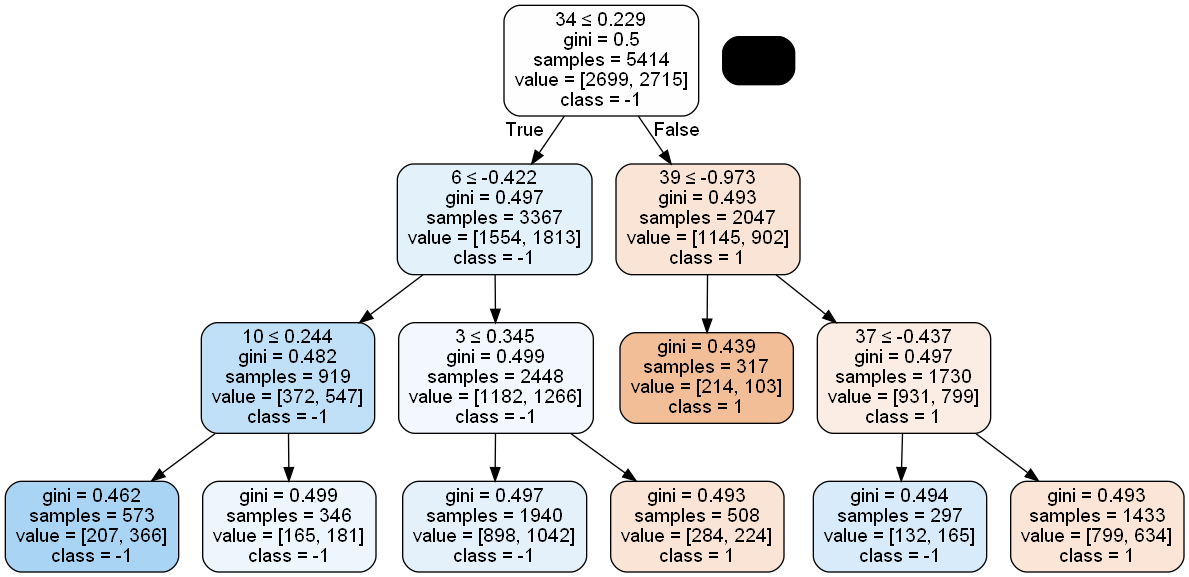

In [10]:
dtc = DecisionTreeClassifier(max_depth=3,min_samples_split=0.125)
dtc.fit(x_train,y_train.label)
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import display, Image
dot_data = export_graphviz(dtc,out_file=None,feature_names=x_train.columns,class_names=y_train.label.astype('str').unique(),filled=True,rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree.png')
display(Image(graph.create_png()))

In [18]:
from adaboost import DtcAdaboost

In [19]:
model = DtcAdaboost(max_depth=2,min_samples_split=0.1,learning_rate=.8,k=1/120,n_estimators=100)
model.fit(x_train,y_train[['label']],y_train.origin,x_val,y_val)

max Accuracy:0.5764119601328903 with numIt 51
max AUC:0.5677117304354555 with numIt 51
max Correlation:0.12699858343323772 with numIt 42


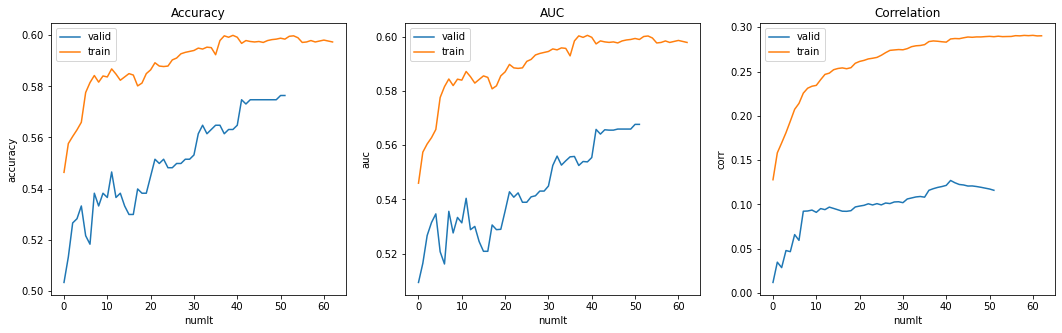

In [20]:
model.plot(x_val,y_val[['label']],y_val.origin)

In [ ]:
def adaBoostTrain(data, label, md = 2, mss = 80, numIt = 250, lr = 0.5, a = 1/120):
    trend = True

    X = data.copy(deep=True)
    y = label.copy(deep=True)
    k = int(y.label.nunique())
    y['weight'] = 1/y.shape[0]

    weakClassArr = []
    alphas = []
    train_accuracy = []
    train_corr = []
    train_cm = []
    train_auc = []
    m = np.shape(X)[0]
    aggProbEst = np.zeros((m,k))

    for i in range(numIt):
        weakClassArr.append(DecisionTreeClassifier(max_depth=md,min_samples_split=mss,random_state=i))
        dtc = weakClassArr[-1]
        dtc.fit(X,y.label,y.weight)
        probEst = dtc.predict_proba(X)
        classEst = [np.argmax(a) if np.argmax(a) > 0 else -1 for a in probEst]
        incorrect = classEst != y.label
        true_positive = (y.label == classEst)&(y.label == 1)

        # if trend:
        #     tn, fp, fn, tp = confusion_matrix(y_true=y.label,y_pred=classEst,sample_weight=y.weight).ravel()
        #     error = (fp+fn+tn-2*tp)/(tn+fp+fn+tp)
        # else:
        error = np.average(incorrect, weights=y.weight)
    
        if error >= 1 - (1 / k):
            weakClassArr.pop(-1)
            print("This weakclassifier is worser than random prediction")
            if len(weakClassArr) == 0:
                raise ValueError(
                    "BaseClassifier in AdaBoostClassifier "
                    "ensemble is worse than random, ensemble "
                    "can not be fit."
                    )
            continue
        
        alpha = 0.5 * lr * ((np.log((1.0 - error) / max(error, 1e-16)) + np.log(k - 1)))    #计算弱学习算法权重alpha,使error不等于0,因为分母不能为0
        if trend:
            alpha += a * lr * np.exp(y.loc[true_positive].weight.sum())
            
        y.weight = np.exp(np.log(y.weight)+ alpha * incorrect * (y.weight > 0))
        y.weight /= y.weight.sum()                                         #根据样本权重公式，更新样本权重
        alphas.append(alpha)                                                     #存储弱学习算法权重
        aggProbEst += alpha * probEst
        aggClassEst = [np.argmax(a) if np.argmax(a) > 0 else -1 for a in aggProbEst] 
        accuracy = accuracy_score(y_pred = aggClassEst,y_true = y.label)
        train_accuracy.append(accuracy)
        train_corr.append(np.corrcoef([-a[1] for a in aggProbEst],y.origin)[1,0])
        train_cm.append(confusion_matrix(y_pred = aggClassEst,y_true = y.label))
        train_auc.append(roc_auc_score(y_score = aggClassEst,y_true = y.label))

        # if accuracy == 1: 
        #     break                                                               #误差为0，退出循环
    return weakClassArr, alphas, train_accuracy, train_corr, train_auc, train_cm

def adaBoostPredict(X, weakClassArr, alphas, k=2):
    numIt = len(weakClassArr)
    m = np.shape(X)[0]
    aggProbEst = np.zeros((m,k))
    for i in range(numIt):
        dtc = weakClassArr[i]
        alpha = alphas[i]
        probEst = dtc.predict_proba(X)
        aggProbEst += alpha * probEst                                            
        aggClassEst = [np.argmax(a) if np.argmax(a) > 0 else -1 for a in aggProbEst]
    return aggClassEst

def adaBoostValid(X,y,weakClassArr, alphas, k=2):
    valid_accuracy = []
    valid_corr = []
    valid_auc = []
    valid_cm = []
    numIt = len(weakClassArr)
    m = np.shape(X)[0]
    aggProbEst = np.zeros((m,k))
    for i in range(numIt):
        dtc = weakClassArr[i]
        alpha = alphas[i]
        probEst = dtc.predict_proba(X)
        aggProbEst += alpha * probEst 
        aggClassEst = [np.argmax(a) if np.argmax(a) > 0 else -1 for a in aggProbEst]  
        valid_accuracy.append(accuracy_score(y_pred = aggClassEst,y_true = y.label))
        valid_corr.append(np.corrcoef([-a[1] for a in aggProbEst],y.origin)[1,0])
        valid_auc.append(roc_auc_score(y_score=aggClassEst,y_true=y.label))
        valid_cm.append(confusion_matrix(y_pred = aggClassEst,y_true = y.label))
    return valid_accuracy,valid_corr,valid_auc,valid_cm

In [ ]:
def adaBoostPlot(train_accuracy,train_auc,train_corr,valid_accuracy,valid_auc,valid_corr):
    plt.figure(figsize=(18,5))
    ax1=plt.subplot(131)
    ax1.plot(valid_accuracy,'b')
    ax1.plot(train_accuracy,'g')
    ax1.set_xlabel('numIt')
    ax1.set_ylabel('accuracy')
    ax1.set_title('Accuracy')
    ax2=plt.subplot(132)
    ax2.plot(valid_corr,'b')
    ax2.plot(train_corr,'g')
    ax2.set_xlabel('numIt')
    ax2.set_ylabel('corr')
    ax2.set_title('Correlation')
    ax3=plt.subplot(133)
    ax3.plot(valid_auc,'b')
    ax3.plot(train_auc,'g')
    ax3.set_xlabel('numIt')
    ax3.set_ylabel('auc')
    ax3.set_title('AUC')
    # plt.suptitle('learning_rate={}'.format())   
    plt.show()

In [ ]:
def lr_md_Plot(lr,md):
    weakClassArr, alphas, train_accuracy, train_corr, train_auc,train_cm = adaBoostTrain(x_train,y_train,mss=20,md=md,lr=lr,numIt=800)
    valid_accuracy,valid_corr,valid_auc,valid_cm = adaBoostValid(x_val,y_val,weakClassArr,alphas)
    plt.figure(figsize=(18,5))
    ax1=plt.subplot(131)
    ax1.plot(valid_accuracy,'b')
    ax1.plot(train_accuracy,'g')
    ax1.set_xlabel('numIt')
    ax1.set_ylabel('accuracy')
    ax1.set_title('Accuracy')
    ax2=plt.subplot(132)
    ax2.plot(valid_corr,'b')
    ax2.plot(train_corr,'g')
    ax2.set_xlabel('numIt')
    ax2.set_ylabel('corr')
    ax2.set_title('Correlation')
    ax3=plt.subplot(133)
    ax3.plot(valid_auc,'b')
    ax3.plot(train_auc,'g')
    ax3.set_xlabel('numIt')
    ax3.set_ylabel('auc')
    ax3.set_title('AUC')
    plt.suptitle('learning_rate={} max_depth={}'.format(lr,md))
    plt.savefig('lr{}md{}.png'.format(lr,md))

In [ ]:
np.linspace(1/120,1/50,5)

In [ ]:
def a_compare(lr,md,mss):
    a_list = np.linspace(1/120,1/50,5)
    plt.figure(figsize=(18,15))
    ax1=plt.subplot(311)
    ax1.set_xlabel('numIt')
    ax1.set_ylabel('accuracy')
    ax1.set_title('Accuracy')
    ax2=plt.subplot(312)
    ax2.set_xlabel('numIt')
    ax2.set_ylabel('corr')
    ax2.set_title('Correlation')
    ax3=plt.subplot(313)
    ax3.set_xlabel('numIt')
    ax3.set_ylabel('auc')
    ax3.set_title('AUC')
    color = {a_list[0]:'r',a_list[1]:'y',a_list[2]:'b',a_list[3]:'g',a_list[4]:'black'}
    for a in a_list:
        weakClassArr, alphas, train_accuracy, train_corr, train_auc, train_cm = adaBoostTrain(x_train,y_train,md=md,mss=mss,lr=lr,a=a)
        valid_accuracy,valid_corr,valid_auc,valid_cm = adaBoostValid(x_val,y_val,weakClassArr,alphas)
        print('*********{}*********'.format(a))
        print('max Accuracy:{} with numIt {}'.format(np.max(valid_accuracy),np.argmax(valid_accuracy)+1))
        print('max Correlation:{} with numIt {}'.format(np.max(valid_corr),np.argmax(valid_corr)+1))
        print('max AUC:{} with numIt {}'.format(np.max(valid_auc),np.argmax(valid_auc)+1))
        ax1.plot(valid_accuracy,color[a],label=a)
        ax2.plot(valid_corr,color[a],label=a)
        ax3.plot(valid_auc,color[a],label=a)
    ax1.legend()
    ax2.legend()
    ax3.legend()
    plt.suptitle('learning_rate={},max_depth={},min_samples_split={}'.format(lr,md,mss))
    plt.show()

In [ ]:
def lr_compare(md=2,mss=2,a=0.1):
    plt.figure(figsize=(18,15))
    ax1=plt.subplot(311)
    ax1.set_xlabel('numIt')
    ax1.set_ylabel('accuracy')
    ax1.set_title('Accuracy')
    ax2=plt.subplot(312)
    ax2.set_xlabel('numIt')
    ax2.set_ylabel('corr')
    ax2.set_title('Correlation')
    ax3=plt.subplot(313)
    ax3.set_xlabel('numIt')
    ax3.set_ylabel('auc')
    ax3.set_title('AUC')
    # color = {0.1:'r',0.2:'y',0.3:'b',0.4:'g',0.5:'black'}
    for lr in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
        weakClassArr, alphas, train_accuracy, train_corr, train_auc, train_cm = adaBoostTrain(x_train,y_train,md=md,mss=mss,lr=lr,a=a)
        valid_accuracy,valid_corr,valid_auc,valid_cm = adaBoostValid(x_val,y_val,weakClassArr,alphas)
        print('*********{}*********'.format(lr))
        print('max Accuracy:{} with numIt {}'.format(np.max(valid_accuracy),np.argmax(valid_accuracy)+1))
        print('max Correlation:{} with numIt {}'.format(np.max(valid_corr),np.argmax(valid_corr)+1))
        print('max AUC:{} with numIt {}'.format(np.max(valid_auc),np.argmax(valid_auc)+1))
        ax1.plot(valid_accuracy,label=lr)
        ax2.plot(valid_corr,label=lr)
        ax3.plot(valid_auc,label=lr)
    ax1.legend()
    ax2.legend()
    ax3.legend()
    plt.suptitle('max_depth={},min_samples_split={},a={}'.format(md,mss,a))
    plt.show()

In [ ]:
def md_compare(lr=.5,mss=2,a=0.1):
    plt.figure(figsize=(18,15))
    ax1=plt.subplot(311)
    ax1.set_xlabel('numIt')
    ax1.set_ylabel('accuracy')
    ax1.set_title('Accuracy')
    ax2=plt.subplot(312)
    ax2.set_xlabel('numIt')
    ax2.set_ylabel('corr')
    ax2.set_title('Correlation')
    ax3=plt.subplot(313)
    ax3.set_xlabel('numIt')
    ax3.set_ylabel('auc')
    ax3.set_title('AUC')
    color = {1:'r',2:'y',3:'b'}
    # def subjob_func(md):
    #     weakClassArr, alphas, train_accuracy, train_corr, train_auc, train_cm = adaBoostTrain(x_train,y_train,md=md,mss=mss,lr=lr,numIt=500)
    #     valid_accuracy,valid_corr,valid_auc,valid_cm = adaBoostValid(x_val,y_val,weakClassArr,alphas)
    #     print('*********{}*********'.format(md))
    #     print('max Accuracy:{} with numIt {}'.format(np.max(valid_accuracy),np.argmax(valid_accuracy)+1))
    #     print('max Correlation:{} with numIt {}'.format(np.max(valid_corr),np.argmax(valid_corr)+1))
    #     print('max AUC:{} with numIt {}'.format(np.max(valid_auc),np.argmax(valid_auc)+1))
    #     ax1.plot(valid_accuracy,color[md],label=md)
    #     ax2.plot(valid_corr,color[md],label=md)
    #     ax3.plot(valid_auc,color[md],label=md)   
    # Parallel(n_jobs=-1)(delayed(subjob_func)(md) for md in [1,2,3,4,5])
    for md in [1,2,3]:
        weakClassArr, alphas, train_accuracy, train_corr, train_auc, train_cm = adaBoostTrain(x_train,y_train,md=md,mss=mss,lr=lr,a=a)
        valid_accuracy,valid_corr,valid_auc,valid_cm = adaBoostValid(x_val,y_val,weakClassArr,alphas)
        print('*********{}*********'.format(md))
        print('max Accuracy:{} with numIt {}'.format(np.max(valid_accuracy),np.argmax(valid_accuracy)+1))
        print('max Correlation:{} with numIt {}'.format(np.max(valid_corr),np.argmax(valid_corr)+1))
        print('max AUC:{} with numIt {}'.format(np.max(valid_auc),np.argmax(valid_auc)+1))
        ax1.plot(valid_accuracy,color[md],label=md)
        ax2.plot(valid_corr,color[md],label=md)
        ax3.plot(valid_auc,color[md],label=md)
    ax1.legend()
    ax2.legend()
    ax3.legend()
    plt.suptitle('learning_rate={},min_samples_split={},a={}'.format(lr,mss,a))
    plt.show()

In [ ]:
def mss_compare(lr,md,a):
    if md == 2:
        mss_list = [0.05,0.075,0.1,0.125,0.2]
    elif md == 3:
        mss_list = [0.01,0.025,0.05,0.075,0.1]
    plt.figure(figsize=(18,15))
    ax1=plt.subplot(311)
    ax1.set_xlabel('numIt')
    ax1.set_ylabel('accuracy')
    ax1.set_title('Accuracy')
    ax2=plt.subplot(312)
    ax2.set_xlabel('numIt')
    ax2.set_ylabel('corr')
    ax2.set_title('Correlation')
    ax3=plt.subplot(313)
    ax3.set_xlabel('numIt')
    ax3.set_ylabel('auc')
    ax3.set_title('AUC')
    color = {mss_list[0]:'r',mss_list[1]:'y',mss_list[2]:'b',mss_list[3]:'g',mss_list[4]:'black'}
    for mss in mss_list:
        weakClassArr, alphas, train_accuracy, train_corr, train_auc, train_cm = adaBoostTrain(x_train,y_train,md=md,mss=mss,lr=lr,a=a)
        valid_accuracy,valid_corr,valid_auc,valid_cm = adaBoostValid(x_val,y_val,weakClassArr,alphas)
        print('*********{}*********'.format(mss))
        print('max Accuracy:{} with numIt {}'.format(np.max(valid_accuracy),np.argmax(valid_accuracy)+1))
        print('max Correlation:{} with numIt {}'.format(np.max(valid_corr),np.argmax(valid_corr)+1))
        print('max AUC:{} with numIt {}'.format(np.max(valid_auc),np.argmax(valid_auc)+1))
        ax1.plot(valid_accuracy,color[mss],label=mss)
        ax2.plot(valid_corr,color[mss],label=mss)
        ax3.plot(valid_auc,color[mss],label=mss)
    ax1.legend()
    ax2.legend()
    ax3.legend()
    plt.suptitle('max_depth={},learning_rate={},a={}'.format(md,lr,a))
    plt.show()

In [ ]:
weakClassArr, alphas, train_accuracy, train_corr, train_auc, train_cm = adaBoostTrain(x_train,y_train,md=2,mss=0.1,lr=0.8,a=1/120,numIt=250)
valid_accuracy,valid_corr,valid_auc,valid_cm = adaBoostValid(x_val,y_val,weakClassArr,alphas)

In [ ]:
adaBoostPlot(train_accuracy,train_auc,train_corr,valid_accuracy,valid_auc,valid_corr)
print('max Accuracy:{} with numIt {}'.format(np.max(valid_accuracy),np.argmax(valid_accuracy)+1))
print('max Correlation:{} with numIt {}'.format(np.max(valid_corr),np.argmax(valid_corr)+1))
print('max AUC:{} with numIt {}'.format(np.max(valid_auc),np.argmax(valid_auc)+1))

In [ ]:
md_compare(lr=1,mss=2,a=1/120)

In [ ]:
mss_compare(lr=1,md=2,a=1/120)

In [ ]:
lr_compare(md=2,mss=0.1,a=1/120)

In [ ]:
a_compare(lr=0.8,md=2,mss=0.1)

In [ ]:
best = 0
crossvalid = pd.DataFrame(index=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],columns=np.linspace(1/120,1/50,8))
for lr in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    for k in np.linspace(1/120,1/50,8):
        def subjob_func(seed):
            x_train,x_val,y_train,y_val = train_test_split(X,y,test_size=0.1,random_state=seed)
            weakClassArr, alphas, train_accuracy, train_corr, train_auc,train_cm = adaBoostTrain(x_train,y_train,md=2,mss=0.1,lr=lr,a=k,numIt=150)
            valid_accuracy,valid_corr,valid_auc,valid_cm = adaBoostValid(x_val,y_val,weakClassArr,alphas)
            numIt = np.argmax(valid_auc)
            return numIt+1,valid_auc[numIt]
        res = Parallel(n_jobs=5)(delayed(subjob_func)(seed) for seed in range(5))
        num = [a[0] for a in res]
        auc = [a[1] for a in res]
        ma = np.mean(auc).round(5)
        crossvalid.loc[lr,k] = ma
        if ma > best:
            best = ma
            print('AUC:{},parameters: lr={},k={}'.format(ma,lr,k),num)
        else:
            print('AUC:{},parameters: lr={},k={}'.format(ma,lr,k))

In [ ]:
plt.figure(figsize=(10,10))
plt.matshow(crossvalid.astype('float32'), fignum=0,cmap=plt.cm.Blues)
plt.xticks(range(8), [0.0083,0.01,0.0117,0.0133,0.015,0.0167,0.0183,0.02],rotation=0,fontsize=14)
plt.yticks(range(10), [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], fontsize=14)
cb = plt.colorbar()

In [ ]:
best = 0
cv = pd.DataFrame(index=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],columns=np.linspace(1/120,1/50,8))
for lr in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    for k in np.linspace(1/120,1/50,8):
        def subjob_func(seed):
            x_train,x_val,y_train,y_val = train_test_split(X,y,test_size=0.1,random_state=seed,stratify=y.label)
            weakClassArr, alphas, train_accuracy, train_corr, train_auc,train_cm = adaBoostTrain(x_train,y_train,md=2,mss=0.1,lr=lr,a=k,numIt=150)
            valid_accuracy,valid_corr,valid_auc,valid_cm = adaBoostValid(x_val,y_val,weakClassArr,alphas)
            numIt = np.argmax(valid_auc)
            return numIt+1,valid_auc[numIt]
        res = Parallel(n_jobs=5)(delayed(subjob_func)(seed) for seed in range(5))
        num = [a[0] for a in res]
        auc = [a[1] for a in res]
        ma = np.mean(auc).round(5)
        cv.loc[lr,k] = ma
        if ma > best:
            best = ma
            print('AUC:{},parameters: lr={},k={}'.format(ma,lr,k),num)
        else:
            print('AUC:{},parameters: lr={},k={}'.format(ma,lr,k))

In [ ]:
plt.figure(figsize=(10,10))
plt.matshow(cv.astype('float32'), fignum=0,cmap=plt.cm.Blues)
plt.xticks(range(8), [0.0083,0.01,0.0117,0.0133,0.015,0.0167,0.0183,0.02],rotation=0,fontsize=14)
plt.yticks(range(10), [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], fontsize=14)
cb = plt.colorbar()

In [ ]:
warnings.filterwarnings('ignore')
# param_test = {'n_estimators':[50,80,100],'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
param_test = {'base_estimator__max_depth':[2,3],'base_estimator__min_samples_split':[400,600,800],'n_estimators':[50,80,100],'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
gsearch = GridSearchCV(estimator = AdaBoostClassifier(DecisionTreeClassifier(),random_state=2022), 
                       param_grid = param_test, scoring='roc_auc',cv=5,n_jobs=-1)
gsearch.fit(x_train,y_train.label)
gsearch.best_params_, gsearch.best_score_

In [ ]:
warnings.filterwarnings('ignore')

model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3,min_samples_split=600),learning_rate=0.5,n_estimators=50,random_state=2022)
model.fit(x_train,y_train.label)
y_pred = model.predict(x_val)
roc_auc_score(y_pred,y_val.label)

In [ ]:
means = gsearch.cv_results_['mean_test_score']
params = gsearch.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:  %r" % (mean,param))